# Predict 2021 Residential Home Sales Price in Durham, NC

This code answers the questions of what is the value of a home in Durham, NC?

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.tree import export_text
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import math

import pickle

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Read the Data

In [3]:
df = pd.read_csv('Durham_homes_sold_2021_YTD.csv')

In [4]:
df.shape

(4585, 32)

In [9]:
df.head().T

0                     1  \
subdivision               The Hills at Southpoint          Orchard Lake   
total_living_area_sqft                      6,079                 1,532   
year_built                                   2010                  2002   
bedrooms                                        6                     3   
full_baths                                      5                     2   
half_baths                                      1                     1   
property_type                            Detached              Detached   
list_price                                 819900                235000   
sold_price                                 798000                243000   
acres                                .26-.5 Acres           0-.25 Acres   
approx_lot_sqft                         12,719.52              7,579.44   
approximate_acres                           0.292                 0.174   
basement                                      Yes                    No   
construction_type                      Site Built            Site Built   
days_on_market                                 56                     3   
closing_date                             1/4/2021              1/4/2021   
fireplace                                       3                     1   
garage                                          4                     0   
hoa_1_fees_required                           Yes                   Yes   
internet_listing                              Yes                   Yes   
list_date                               9/16/2020             10/8/2020   
master_bedroom_1st_floor                       No                    No   
new_construction                               No                    No   
total_baths                                     6                     3   
zip                                         27713                 27713   
inside_city                                   Yes                   Yes   
hoa_y/n                                       NaN                   Yes   
elementary_school_1            Durham - Creekside    Durham - Southwest   
high_school_1                     Durham - Jordan     Durham - Hillside   
middle_school_1                  Durham - Githens  Durham - Lowes Grove   
city                                       Durham                Durham   
restrictive_covenants                         Yes                   Yes   

                                             2                    3  \
subdivision               Not in a Subdivision        Hickory Ridge   
total_living_area_sqft                   4,494                1,914   
year_built                                1910                 1997   
bedrooms                                     4                    3   
full_baths                                   4                    2   
half_baths                                   0                    1   
property_type                         Detached             Detached   
list_price                             1153000               268500   
sold_price                             1153000               249500   
acres                             .26-.5 Acres        .76-.99 Acres   
approx_lot_sqft                      11,325.60            38,768.40   
approximate_acres                         0.26                 0.89   
basement                                   Yes                   No   
construction_type                   Site Built           Site Built   
days_on_market                               1                    1   
closing_date                          1/4/2021             1/4/2021   
fireplace                                   4+                    1   
garage                                       0                    2   
hoa_1_fees_required                         No                  NaN   
internet_listing                           Yes                  Yes   
list_date                            11/5/2020           11/10/2020   
master_bed

## Clean the Data

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [13]:

for c in ['list_price', 'sold_price', 'total_living_area_sqft', 'approx_lot_sqft']:
    df[c] = df[c].str.replace('$', '')
    df[c] = df[c].str.replace(',', '')

for i in ['list_price', 'sold_price', 'total_living_area_sqft']:
    df[i] = df[i].astype(int)
    
for f in ['approx_lot_sqft']:
    df[f] = df[f].astype(float)


<ipython-input-13-02efb494e398>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[c] = df[c].str.replace('$', '')


In [14]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

subdivision
['The Hills at Southpoint' 'Orchard Lake' 'Not in a Subdivision'
 'Hickory Ridge' 'Wynterfield']
646

total_living_area_sqft
[6079 1532 4494 1914 1681]
2030

year_built
[2010 2002 1910 1997 2005]
117

bedrooms
[6 3 4 2 5]
9

full_baths
[5 2 4 1 3]
7

half_baths
[1 0 2 3]
4

property_type
['Detached' 'Attached' 'Condo' 'Manufactured']
4

list_price
[ 819900  235000 1153000  268500  225000]
1573

sold_price
[ 798000  243000 1153000  249500  230000]
1825

acres
['.26-.5 Acres' '0-.25 Acres' '.76-.99 Acres' '.51-.75 Acres'
 '1-2.9 Acres']
8

approx_lot_sqft
[12719.52  7579.44 11325.6  38768.4   1568.16]
699

approximate_acres
[0.292 0.174 0.26  0.89  0.036]
699

basement
['Yes' 'No']
2

construction_type
['Site Built' 'Manufactured' 'Modular' 'Insulated Concrete Forms'
 'Pre-Cast Concrete']
5

days_on_market
[56  3  1  6 48]
141

closing_date
['1/4/2021' '1/5/2021' '1/6/2021' '1/7/2021' '1/8/2021']
223

fireplace
['3' '1' '4+' '0' '2']
5

garage
[4 0 2 1 3]
8

hoa_1_fees_requir

In [15]:
# prof = ProfileReport(df)

In [16]:
df['closing_date'] = pd.to_datetime(df['closing_date'])

In [17]:
df['list_date'] = pd.to_datetime(df['list_date'])

In [18]:
df.sort_values(by=['closing_date'], inplace=True)

In [19]:
df['days_on_market'] = (df['closing_date'] - df['list_date']).dt.days

In [20]:
df['closing_month'] = df['closing_date'].dt.month

In [21]:
df['closing_day'] = df['closing_date'].dt.day

In [22]:
del df['closing_date']

In [23]:
del df['list_date']

In [25]:
df['fireplace'] = df['fireplace'].replace({'4+':'4'})
df['fireplace'].astype(int)
df['fireplace'].value_counts()

1    2677
0    1723
2     143
3      28
4      14
Name: fireplace, dtype: int64

In [26]:
df['zip'] = df['zip'].str[:5]
df['zip'].unique()

array(['27713', '27703', '27712', '27701', '27705', '27704', '27707',
       '27560', '27702', '27517', '27714', '27519'], dtype=object)

In [27]:
del df['city']

### Handle Missing Values

In [29]:
df.isna().sum()

subdivision                    0
total_living_area_sqft         0
year_built                     0
bedrooms                       0
full_baths                     0
half_baths                     0
property_type                  0
list_price                     0
sold_price                     0
acres                          0
approx_lot_sqft                0
approximate_acres              0
basement                       0
construction_type              0
days_on_market                 0
fireplace                      0
garage                         0
hoa_1_fees_required         1553
internet_listing               0
master_bedroom_1st_floor       0
new_construction               0
total_baths                    0
zip                            0
inside_city                    0
hoa_y/n                      977
elementary_school_1            0
high_school_1                  0
middle_school_1                0
restrictive_covenants          0
closing_month                  0
closing_da

In [31]:
df['hoa_y/n'].value_counts()

Yes    2552
No     1056
Name: hoa_y/n, dtype: int64

In [32]:
df['hoa_1_fees_required'].isnull().sum()

1553

In [33]:
df.reset_index(drop=True)

subdivision  total_living_area_sqft  \
0                     The Hills at Southpoint                    6079   
1                                Rustica Oaks                    1502   
2                                  Ridgefield                    2058   
3                                   Briardale                    2444   
4                                  Grove Park                    2474   
5                                Auburn Trace                    2351   
6                                 Wynterfield                    1681   
7                               Hickory Ridge                    1914   
8                        Not in a Subdivision                    4494   
9                                Orchard Lake                    1532   
10                       Not in a Subdivision                    2384   
11                                  Homeplace                    1075   
12                             Vantage Pointe                    1423   
13                            Croasdaile Farm                    4433   
14                               Fendol Farms                    2447   
15                             Northgate Park                    1232   
16                                   Woodlake                    1346   
17                       Not in a Subdivision                    3233   
18                         University Estates                    2464   
19                               Fendol Farms                    2429   
20                              Sherron Farms                    2046   
21                       Not in a Subdivision                    2288   
22                                  Graystone                    1244   
23                       Not in a Subdivision                    1458   
24                            Stratford Lakes                    1876   
25                       Not in a Subdivision                    1181   
26                       Not in a Subdivision                    1358   
27                                  Pinehurst                    1332   
28                            Brogden Heights                    1611   
29                          Hope Valley Farms                    1345   
30                                   New Hope                     984   
31                          Clayton Crossings                    1620   
32        West Brier Townes at Alexander Park                    2198   
33                              Sunset Valley                    2620   
34                       Wyndmoor at the Park                    2490   
35                               Fendol Farms                    2955   
36                               Autumn Ridge                    3408   
37                          Chancellors Ridge                    1957   
38                       Pleasant Green Woods                    2828   
39                    Duke Tower Condominiums                     600   
40                               Rustica Oaks                    1540   
41                       Not in a Subdivision                    1373   
42                            Croasdaile Farm                    2801   
43                          Creekside Commons                    2339   
44                       Not in a Subdivision                    1853   
45                       Not in a Subdivision                    1439   
46                       Not in a Subdivision                    1680   
47                                   Old Farm                    1439   
48                                Forest Oaks                    1400   
49                             Dogwood Pointe                    1809   
50                             Hanover Pointe                    1920   
51                             Thompson Ridge                    1464   
52                                 Brightleaf                    2823   
53                                  Wingbrook                    2585   
54                 

In [34]:
df['hoa_1_fees_required'].fillna(df['hoa_y/n'], inplace=True)

In [35]:
df['hoa_1_fees_required'] = np.where(df['subdivision'] == 'Not in a Subdivision', 'No', df['hoa_1_fees_required'])

In [36]:
hoa_yes = list(df[df['hoa_1_fees_required'] == 'Yes']['subdivision'])

In [37]:
hoa_no = list(df[df['hoa_1_fees_required'] == 'No']['subdivision'])

In [38]:
df['hoa_1_fees_required'] = np.where((df['hoa_1_fees_required'].isnull() & df['subdivision'].isin(hoa_yes)), 'Yes', df['hoa_1_fees_required'])

In [39]:
df['hoa_1_fees_required'] = np.where((df['hoa_1_fees_required'].isnull() & df['subdivision'].isin(hoa_no)), 'No', df['hoa_1_fees_required'])

In [40]:
df['hoa_1_fees_required'] = np.where(df['hoa_1_fees_required'].isnull(), 'No', df['hoa_1_fees_required'])

In [41]:
df['hoa_1_fees_required'].isnull().sum()

0

In [42]:
del df['hoa_y/n']
del df['list_price']

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4585 entries, 0 to 4584
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   subdivision               4585 non-null   object 
 1   total_living_area_sqft    4585 non-null   int32  
 2   year_built                4585 non-null   int64  
 3   bedrooms                  4585 non-null   int64  
 4   full_baths                4585 non-null   int64  
 5   half_baths                4585 non-null   int64  
 6   property_type             4585 non-null   object 
 7   sold_price                4585 non-null   int32  
 8   acres                     4585 non-null   object 
 9   approx_lot_sqft           4585 non-null   float64
 10  approximate_acres         4585 non-null   float64
 11  basement                  4585 non-null   object 
 12  construction_type         4585 non-null   object 
 13  days_on_market            4585 non-null   int64  
 14  fireplac

### Numerical Features

In [45]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)

In [46]:
categorical

['subdivision',
 'property_type',
 'acres',
 'basement',
 'construction_type',
 'fireplace',
 'hoa_1_fees_required',
 'internet_listing',
 'master_bedroom_1st_floor',
 'new_construction',
 'zip',
 'inside_city',
 'elementary_school_1',
 'high_school_1',
 'middle_school_1',
 'restrictive_covenants']

In [47]:
numerical = list(df.dtypes[df.dtypes != 'object'].index)

In [48]:
numerical

['total_living_area_sqft',
 'year_built',
 'bedrooms',
 'full_baths',
 'half_baths',
 'sold_price',
 'approx_lot_sqft',
 'approximate_acres',
 'days_on_market',
 'garage',
 'total_baths',
 'closing_month',
 'closing_day']

In [49]:
df[numerical].describe().round(5)

total_living_area_sqft  year_built    bedrooms  full_baths  half_baths  \
count              4585.00000  4585.00000  4585.00000  4585.00000  4585.00000   
mean               1959.68419  1993.24995     3.14613     2.13195     0.57514   
std                 822.90962    27.47785     0.79786     0.67056     0.52018   
min                 240.00000  1890.00000     0.00000     1.00000     0.00000   
25%                1431.00000  1978.00000     3.00000     2.00000     0.00000   
50%                1819.00000  2002.00000     3.00000     2.00000     1.00000   
75%                2300.00000  2017.00000     4.00000     2.00000     1.00000   
max                9582.00000  2021.00000     8.00000     7.00000     3.00000   

         sold_price  approx_lot_sqft  approximate_acres  days_on_market  \
count  4.585000e+03     4.585000e+03         4585.00000      4585.00000   
mean   3.788241e+05     1.354742e+04            0.31101        79.30927   
std    2.021272e+05     4.266006e+04            0.97934        91.26893   
min    5.500000e+04     0.000000e+00            0.00000         0.00000   
25%    2.680120e+05     3.528360e+03            0.08100        34.00000   
50%    3.375750e+05     7.710120e+03            0.17700        45.00000   
75%    4.325000e+05     1.306800e+04            0.30000        79.00000   
max    3.500000e+06     1.907928e+06           43.80000      1604.00000   

           garage  total_baths  closing_month  closing_day  
count  4585.00000   4585.00000     4585.00000   4585.00000  
mean      1.07241      2.70709        5.81309     17.21352  
std       0.96897      0.87873        2.69957      8.83988  
min       0.00000      1.00000        1.00000      1.00000  
25%       0.00000      2.00000        4.00000     10.00000  
50%       1.00000      3.00000        6.00000     17.00000  
75%       2.00000      3.00000        8.00000     25.00000  
max       9.00000      9.00000       10.00000     31.00000

In [50]:
df[numerical].quantile([.90, .95, .99])

total_living_area_sqft  year_built  bedrooms  full_baths  half_baths  \
0.90                 2913.00      2021.0       4.0         3.0         1.0   
0.95                 3309.80      2021.0       4.0         3.0         1.0   
0.99                 4878.08      2021.0       5.0         4.0         2.0   

      sold_price  approx_lot_sqft  approximate_acres  days_on_market  garage  \
0.90    586347.0       23417.8560            0.53760           206.0     2.0   
0.95    680000.0       34351.4160            0.78860           253.0     2.0   
0.99   1100000.0      102118.5792            2.34432           382.8     3.0   

      total_baths  closing_month  closing_day  
0.90          4.0            9.0         29.0  
0.95          4.0           10.0         30.0  
0.99          5.0           10.0         31.0

<AxesSubplot:xlabel='sold_price', ylabel='Count'>

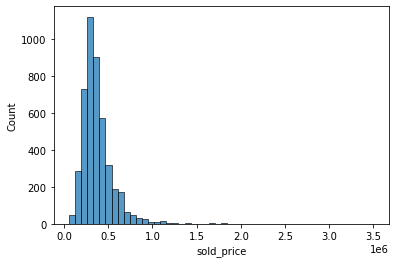

In [51]:
sns.histplot(df.sold_price, bins=50)

<AxesSubplot:xlabel='sold_price', ylabel='Count'>

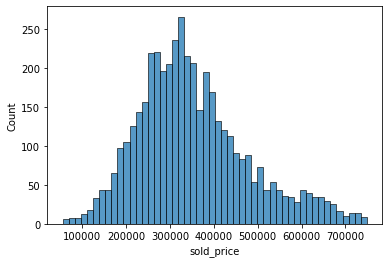

In [52]:
sns.histplot(df.sold_price[df.sold_price < 750000], bins=50)

<AxesSubplot:>

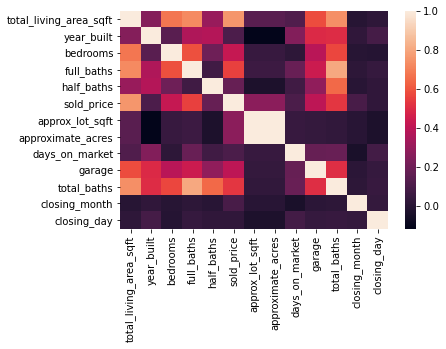

In [53]:
corr = df[numerical].corr()
sns.heatmap(corr)

In [54]:
price_logs = np.log1p(df.sold_price)

<AxesSubplot:xlabel='sold_price', ylabel='Count'>

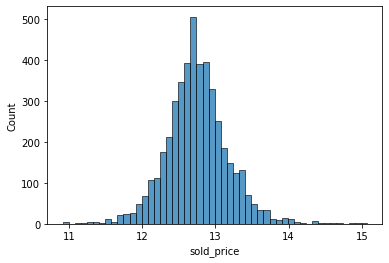

In [55]:
sns.histplot(price_logs, bins=50)

## Split the Data

In [56]:
df_full_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, shuffle=False)

In [57]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [58]:
y_full_train = np.log1p(df_full_train.sold_price.values)
y_train = np.log1p(df_train.sold_price.values)
y_val = np.log1p(df_val.sold_price.values)
y_test = np.log1p(df_test.sold_price.values)

In [59]:
del df_full_train['sold_price']
del df_train['sold_price']
del df_val['sold_price']
del df_test['sold_price']

## Train the Models

In [60]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [61]:
models = {
    "Linear Regression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor()
}

In [62]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " Score: {:.5}".format(model.score(X_val, y_val)))

Linear Regression Score: -8.8505e+07
DecisionTree Score: 0.59909
Random Forest Score: 0.79079
XGBoost Score: 0.81412


### Decision Tree Regressor

In [65]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred_val = dt.predict(X_val)
mse = mean_squared_error(y_val, y_pred_val)

print("Score: {:.5}".format(dt.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

Score: 0.62021
RMSE: 0.2505


In [66]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- total_living_area_sqft <= 1732.50
|   |--- total_living_area_sqft <= 1177.00
|   |   |--- approx_lot_sqft <= 602957.53
|   |   |   |--- subdivision=Bentwood Park <= 0.50
|   |   |   |   |--- total_living_area_sqft <= 777.50
|   |   |   |   |   |--- year_built <= 1999.00
|   |   |   |   |   |   |--- subdivision=Not in a Subdivision <= 0.50
|   |   |   |   |   |   |   |--- zip=27701 <= 0.50
|   |   |   |   |   |   |   |   |--- subdivision=Bowden Rebekah Prop <= 0.50
|   |   |   |   |   |   |   |   |   |--- closing_day <= 10.50
|   |   |   |   |   |   |   |   |   |   |--- year_built <= 1950.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [12.16]
|   |   |   |   |   |   |   |   |   |   |--- year_built >  1950.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- closing_day >  10.50
|   |   |   |   |   |   |   |   |   |   |--- total_living_area_sqft <= 698.50
|   |   |   |   |   |   |   |   |   |   |   |--- 

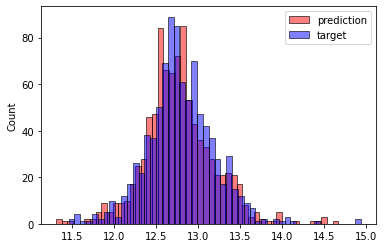

In [67]:
sns.histplot(y_pred_val, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

In [68]:
scores = []

for depth in [None, 2, 3, 4]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        
        scores.append((depth, s, rmse))

columns = ['max_depth', 'min_samples_leaf', 'rmse']
dt_scores = pd.DataFrame(scores, columns=columns)     

dt_scores_pivot = dt_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['rmse'])
dt_scores_pivot.round(3)

rmse                     
max_depth           NaN    2.0    3.0    4.0
min_samples_leaf                            
1                 0.260  0.282  0.268  0.264
5                 0.254  0.282  0.268  0.265
10                0.231  0.282  0.268  0.254
15                0.229  0.282  0.268  0.259
20                0.222  0.282  0.266  0.252
100               0.258  0.282  0.272  0.263
200               0.267  0.282  0.276  0.268
500               0.286  0.286  0.286  0.286

#### Specifying no max_depth and using minimum leaf of 20 yields the best RMSE

In [69]:
dt = DecisionTreeRegressor(min_samples_leaf=20)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rsme = np.sqrt(mse)
score = dt.score(X_val, y_val)
print("Score: {:.5}".format(dt.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

Score: 0.70274
RMSE: 0.22162


### Random Forest Regressor

In [70]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

print("Score: {:.5}".format(rf.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))   

Score: 0.79465
RMSE: 0.1842


In [71]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)

        scores.append((d, n, rmse))
    
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'rmse'])
df_scores    

max_depth  n_estimators      rmse
0           5            10  0.242719
1           5            20  0.235861
2           5            30  0.235475
3           5            40  0.235111
4           5            50  0.234652
5           5            60  0.234070
6           5            70  0.233778
7           5            80  0.233515
8           5            90  0.234117
9           5           100  0.233880
10          5           110  0.233721
11          5           120  0.233581
12          5           130  0.233320
13          5           140  0.232870
14          5           150  0.232545
15          5           160  0.232534
16          5           170  0.232377
17          5           180  0.232413
18          5           190  0.232379
19          5           200  0.232463
20         10            10  0.212415
21         10            20  0.202534
22         10            30  0.201117
23         10            40  0.200964
24         10            50  0.199627
25         10            60  0.199288
26         10            70  0.198458
27         10            80  0.198000
28         10            90  0.198390
29         10           100  0.198358
30         10           110  0.198748
31         10           120  0.198955
32         10           130  0.198544
33         10           140  0.198088
34         10           150  0.197847
35         10           160  0.197830
36         10           170  0.197630
37         10           180  0.197288
38         10           190  0.197279
39         10           200  0.197137
40         15            10  0.202303
41         15            20  0.190839
42         15            30  0.188436
43         15            40  0.188628
44         15            50  0.187434
45         15            60  0.187295
46         15            70  0.187210
47         15            80  0.187138
48         15            90  0.187582
49         15           100  0.187650
50         15           110  0.187975
51         15           120  0.188173
52         15           130  0.187863
53         15           140  0.187595
54         15           150  0.186992
55         15           160  0.186911
56         15           170  0.186726
57         15           180  0.186536
58         15           190  0.186455
59         15           200  0.186413

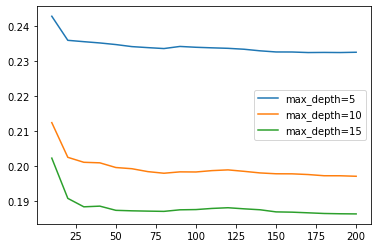

In [72]:
colors = ['blue', 'orange', 'red']
values = [5, 10, 15]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.max_depth == s]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % s)

plt.legend()

In [73]:
rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

print("Score: {:.5}".format(rf.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

Score: 0.78968
RMSE: 0.18641


### XGBoost

In [135]:
parameters = {
    'eta': [0.3], 
    'max_depth': [5],
    'min_child_weight': [1],    
    'objective': ['reg:linear'],
    'nthread': [8]
}

#xgbr = XGBRegressor(parameters)

for d in [0.3, 0.1, 0.01]:
    xgbr = XGBRegressor(eta=d, max_depth=5, min_child_weight=1, objective='reg:linear', nthread=8)
    xgbr.fit(X_train, y_train)

    y_pred = xgbr.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    print("ETA: {:.5}".format(d))
    print("Score: {:.5}".format(xgbr.score(X_val, y_val)))
    print("RMSE: {:.5}".format(np.sqrt(mse)))
    print()

[02:37:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
ETA: 0.3
Score: 0.82482
RMSE: 0.17013

[02:37:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
ETA: 0.1
Score: 0.81262
RMSE: 0.17595

[02:37:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
ETA: 0.01
Score: -124.87
RMSE: 4.5604



In [74]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

print("Score: {:.5}".format(xgbr.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

Score: 0.81412
RMSE: 0.17525


## Choose the Best Model

In [77]:
dt = DecisionTreeRegressor(min_samples_leaf=20)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rsme = np.sqrt(mse)
score = dt.score(X_val, y_val)
print("Score: {:.5}".format(dt.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

Score: 0.70274
RMSE: 0.22162


In [78]:
rf = RandomForestRegressor(n_estimators=200, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

print("Score: {:.5}".format(rf.score(X_val, y_val)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

Score: 0.79606
RMSE: 0.18356


In [136]:
    xgbr = XGBRegressor(eta=0.3, max_depth=5, min_child_weight=1, objective='reg:linear', nthread=8)
    xgbr.fit(X_train, y_train)

    y_pred = xgbr.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    print("Score: {:.5}".format(xgbr.score(X_val, y_val)))
    print("RMSE: {:.5}".format(np.sqrt(mse)))

[02:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Score: 0.82482
RMSE: 0.17013


### XGBoost Regressor is the best model for this data!

## Validate the Model

In [138]:
dv = DictVectorizer(sparse=False)

full_train_dict = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [139]:
xgbr = XGBRegressor(eta=0.3, max_depth=5, min_child_weight=1, objective='reg:linear', nthread=8)
xgbr.fit(X_full_train, y_full_train)

y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Score: {:.5}".format(xgbr_grid.score(X_test, y_test)))
print("RMSE: {:.5}".format(np.sqrt(mse)))

[02:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Score: 0.82926
RMSE: 0.16693


## Save the Model

In [140]:
import pickle

In [144]:
output_file = 'model_xgb.bin'

In [145]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, xgbr), f_out)